In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, os, glob, time
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)

In [2]:
# global variable
BATCH_SIZE = 1024
EPOCH = 200

In [3]:
transform = transforms.Compose([transforms.Resize((64, 64)), 
                                transforms.ToTensor(),
                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalization 
                               ])
cartoon_set = datasets.ImageFolder('./DL_HW3/cartoon', transform)
cartoon_loader = torch.utils.data.DataLoader(dataset=cartoon_set, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.conv_encode = nn.Sequential( 
            nn.Conv2d(3, 64, 3, 2, 1), #(64, 64, 3) -> (32, 32, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, 3, 2, 1), #(32, 32, 64) -> (16, 16, 128)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 256, 3, 2, 1), #(16, 16, 128) -> (8, 8, 256)
            nn.BatchNorm2d(256),
            nn.ReLU(),)
        self.fc1 = nn.Linear(8*8*256, 128) # to generate mean
        self.fc2 = nn.Linear(8*8*256, 128) # to generate log variance
    
        self.fc3 = nn.Linear(128, 8*8*256) 
        self.conv_decode = nn.Sequential( 
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1), #(8, 8, 256) -> (16, 16, 128)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1), #(16, 16, 128) -> (32, 32, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 3, 3, 2, 1, 1), #(32, 32, 64) -> (64, 64, 3)
            nn.BatchNorm2d(3),
            nn.Sigmoid(),)
        
    def encoder(self, x):
        # encode
        h = self.conv_encode(x)
        h = h.view(h.size(0), -1)
        
        # generate mean & std
        mu = self.fc1(h)
        log_var = self.fc2(h)
        
        return mu, log_var
    
    def decoder(self, x, batch_size):
        h = self.fc3(x)
        h = h.view(batch_size, 256, 8, 8) # reshape to image
        out = self.conv_decode(h)
        return out
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        epslion = torch.randn_like(std)
        
        return mu + std * epslion # z
    
    def forward(self, x, batch_size):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decoder(z, batch_size)
        
        return x_reconst, mu, log_var

In [22]:
def plot_imgs(imgs, title):
    fig = plt.gcf()
    fig.set_size_inches((12, 5))
    fig.suptitle(title, fontsize=20, color='r')
    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        ax.imshow(imgs[i].permute(1, 2, 0))

In [6]:
model = VAE()
model = model.to(device)
print(model)

VAE(
  (conv_encode): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=16384, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=16384, bias=True)
  (conv_decode): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [7]:
num_params = np.sum([torch.numel(param) for param in model.parameters()])
print(num_params)

7050761


/usr/bin/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch: 0 | loss: 6061094.0
epoch: 1 | loss: 5904845.5
epoch: 2 | loss: 5834669.0
epoch: 3 | loss: 5765579.0
epoch: 4 | loss: 5703567.0
epoch: 5 | loss: 5651286.5
epoch: 6 | loss: 5607825.5
epoch: 7 | loss: 5640395.0
epoch: 8 | loss: 5533467.0
epoch: 9 | loss: 5482805.0
epoch: 10 | loss: 5417640.5


/usr/bin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


epoch: 11 | loss: 5389972.0
epoch: 12 | loss: 5350356.5
epoch: 13 | loss: 5300580.0
epoch: 14 | loss: 5259217.0
epoch: 15 | loss: 5198890.0
epoch: 16 | loss: 5169225.0
epoch: 17 | loss: 5135886.5
epoch: 18 | loss: 5078153.0
epoch: 19 | loss: 5051952.5
epoch: 20 | loss: 5007082.5
epoch: 21 | loss: 4971258.0
epoch: 22 | loss: 4947344.0
epoch: 23 | loss: 4891319.0
epoch: 24 | loss: 4870034.0
epoch: 25 | loss: 4829222.0
epoch: 26 | loss: 4807081.5
epoch: 27 | loss: 4740954.5
epoch: 28 | loss: 4713952.5
epoch: 29 | loss: 4697628.5
epoch: 30 | loss: 4666264.5
epoch: 31 | loss: 4624563.5
epoch: 32 | loss: 4622736.5
epoch: 33 | loss: 4556504.5
epoch: 34 | loss: 4546351.5
epoch: 35 | loss: 4529607.5
epoch: 36 | loss: 4460863.0
epoch: 37 | loss: 4425812.0
epoch: 38 | loss: 4397549.5
epoch: 39 | loss: 4396665.0
epoch: 40 | loss: 4361958.0
epoch: 41 | loss: 4344933.5
epoch: 42 | loss: 4317904.0
epoch: 43 | loss: 4280344.5
epoch: 44 | loss: 4250925.5
epoch: 45 | loss: 4227677.0
epoch: 46 | loss: 41

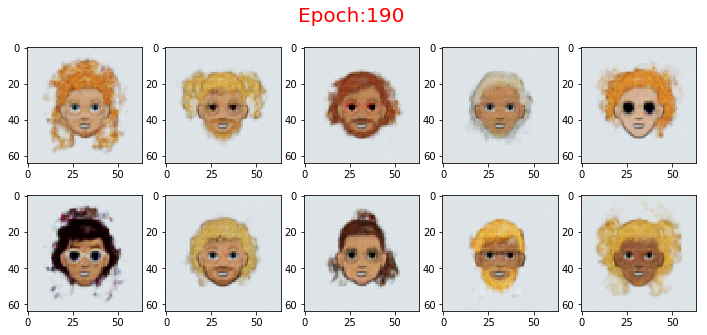

In [8]:
optimizer = torch.optim.Adam(model.parameters())
# training
history_loss = []
start_time = time.time()

for epoch in range(EPOCH):
    model.train()
    for idx, (batch_X, batch_y) in enumerate(cartoon_loader):
        batch_X = batch_X.to(device)
        x_reconst, mu, log_var = model(batch_X, batch_X.size(0))
        
        # calculate loss
        reconst_loss = F.binary_cross_entropy(x_reconst, batch_X, size_average=False)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = reconst_loss + kl_divergence
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('epoch:', epoch, '| loss:', loss.item())
    torch.save(model.state_dict(), 'ckpt/VAE_model.pth')
    
    if(epoch % 10 == 0):
        with torch.no_grad():
            model.eval()
            sample = torch.randn(1024, 128).to(device)
            imgs = model.decoder(sample, batch_size=BATCH_SIZE).cpu()
            plot_imgs(imgs, 'Epoch:'+ str(epoch))
        plt.savefig('training(epoch:' + str(epoch) + ').png')
        
        
    history_loss.append(loss.item())
    
end_time = time.time()
print('Total cost time',time.strftime("%H hr %M min %S sec", time.gmtime(end_time - start_time)))
  

#### training cruve

Text(0, 0.5, 'Loss')

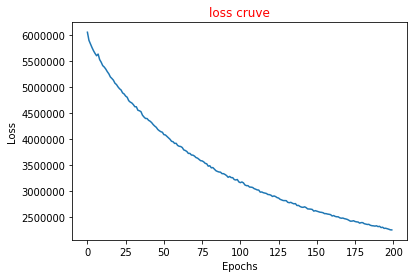

In [28]:
plt.plot(history_loss)
plt.title('loss cruve', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')

#### compare origin images v.s. reconstruction images

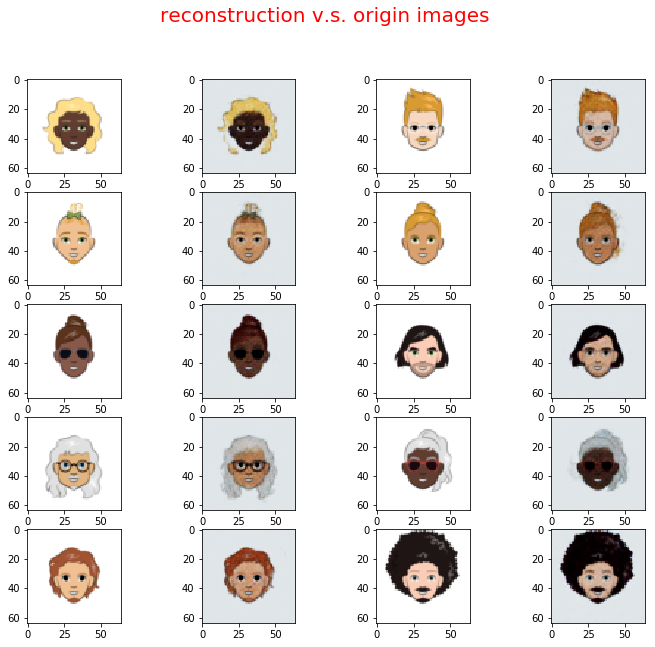

In [66]:
fig = plt.gcf()
fig.set_size_inches((12, 10))
fig.suptitle('reconstruction v.s. origin images', fontsize=20, color='r')
idx = 0
pos_idx = 0
for _ in range(20):
    if(pos_idx == 20):
        break
    ax = plt.subplot(5, 4, pos_idx+1)
    ax.imshow(batch_X[idx].permute(1, 2, 0))
    
    ax = plt.subplot(5, 4, pos_idx+2)
    ax.imshow(x_reconst[idx].permute(1, 2, 0))
    pos_idx += 2
    idx += 1

#### samples

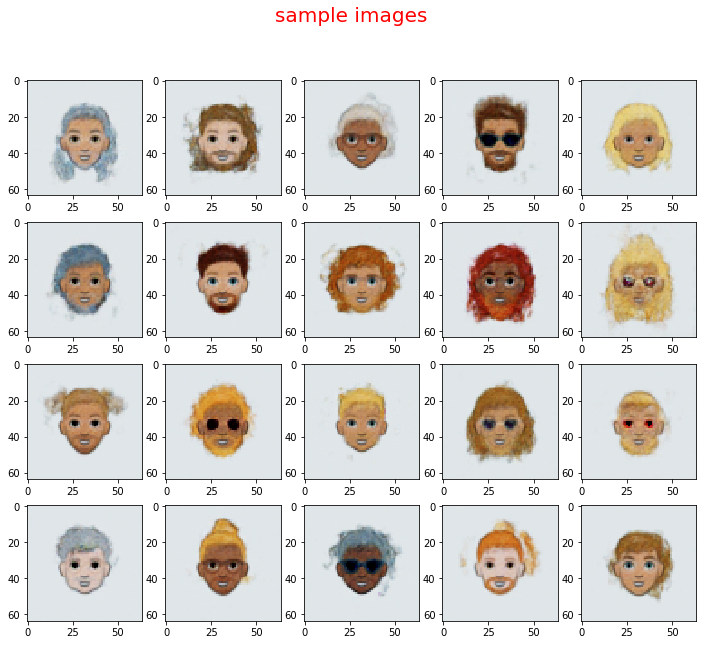

In [21]:
with torch.no_grad():
    model.eval()
    sample = torch.randn(1024, 128).to(device)
    imgs = model.decoder(sample, batch_size=BATCH_SIZE).cpu()
    plot_imgs(imgs, 'sample images')